In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from scipy.stats import skew, kurtosis

# Wine Quality

## Introduction

Living in France, you may have asked yourself what makes French wine so good. Well, our objective here is to determine what physicochemical properties influence human sensory perception of quality. 

We are working with a dataset of Portuguese "Vinho Verde" wine containing 1599 observations from which we have extracted 11 physicochemical properties and determined their quality on a scale from 3 to 8. We face a vectorial space of dimension 11 where the objective variable is discrete and ordinal (3-10). Therefore, we can solve either a regression problem trying to predict the `quality` or a classification problem where we consider a wine 'good' if `quality` ≥ 7 (1) and 'not good' if not (0). The issue with treating $Y$ as categorical (classification) is that we lose the distance metric, that is because an error when predicting 3 instead of 8 is much worse than an error predicting 7 instead of 8. In regression, this ordinal structure is naturally preserved. Ref https://en.wikipedia.org/wiki/Skewness

In [29]:
df = pd.read_csv('winequality-red.csv', sep=',')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
stats = df.describe().T
stats['skewness'] = df.skew()
stats['kurtosis'] = df.kurtosis()

In [5]:
stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000,0.982751,1.132143
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000,0.671593,1.225542
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000,0.318337,-0.788998
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000,4.540655,28.617595
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100,5.680347,41.715787
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000,1.250567,2.023562
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000,1.515531,3.809824
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369,0.071288,0.934079
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000,0.193683,0.806943
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000,2.428672,11.720251


# Exploratory Data Analysis: distribution and dependency structure

Some of the plots are inspired by https://www.kaggle.com/code/aminesudesolak/eda-red-wine-quality

We will analyze the geometry of the variables, their marginal distributions, and the dependency structure. To do this, we examine the skewness and kurtosis. For a unimodal distribution, negative skew typically indicates that the tail is on the left side of the distribution, while positive skew indicates that the tail is on the right. In cases where one tail is long but the other tail is fat, skewness does not follow a simple rule. From the statistics output, we observe that `chlorides`, `residual sugar`, and `sulphates` exhibit positive skewness and high kurtosis, suggesting the presence of a significant right tail. This hypothesis is visually confirmed in the histograms (shown in red).

What does this imply for a decision tree? Catastrophe. Individual decision trees suffer from **high variance** so small changes in data can produce very different splits. Random Forests mitigate this through **bagging and ensemble averaging**, techniques that we will discuss later. In fact, RF are invariant to monotonic transformations and do not require feature scaling, hence, we are not going to scale our data yet.

$Y$ has an approximately gaussian distribution centered around 5-6. The extreme classes (3-8) are rare events and we have no samples with quality 0, 1, or 2. The 3rd quartile of `quality` is 6 so a naive classifier predicting 'not a good wine' (quality <7) would achieve 86% accuracy. A weighted loss fonction or resampling would be a good idea if we want to beat that baseline.

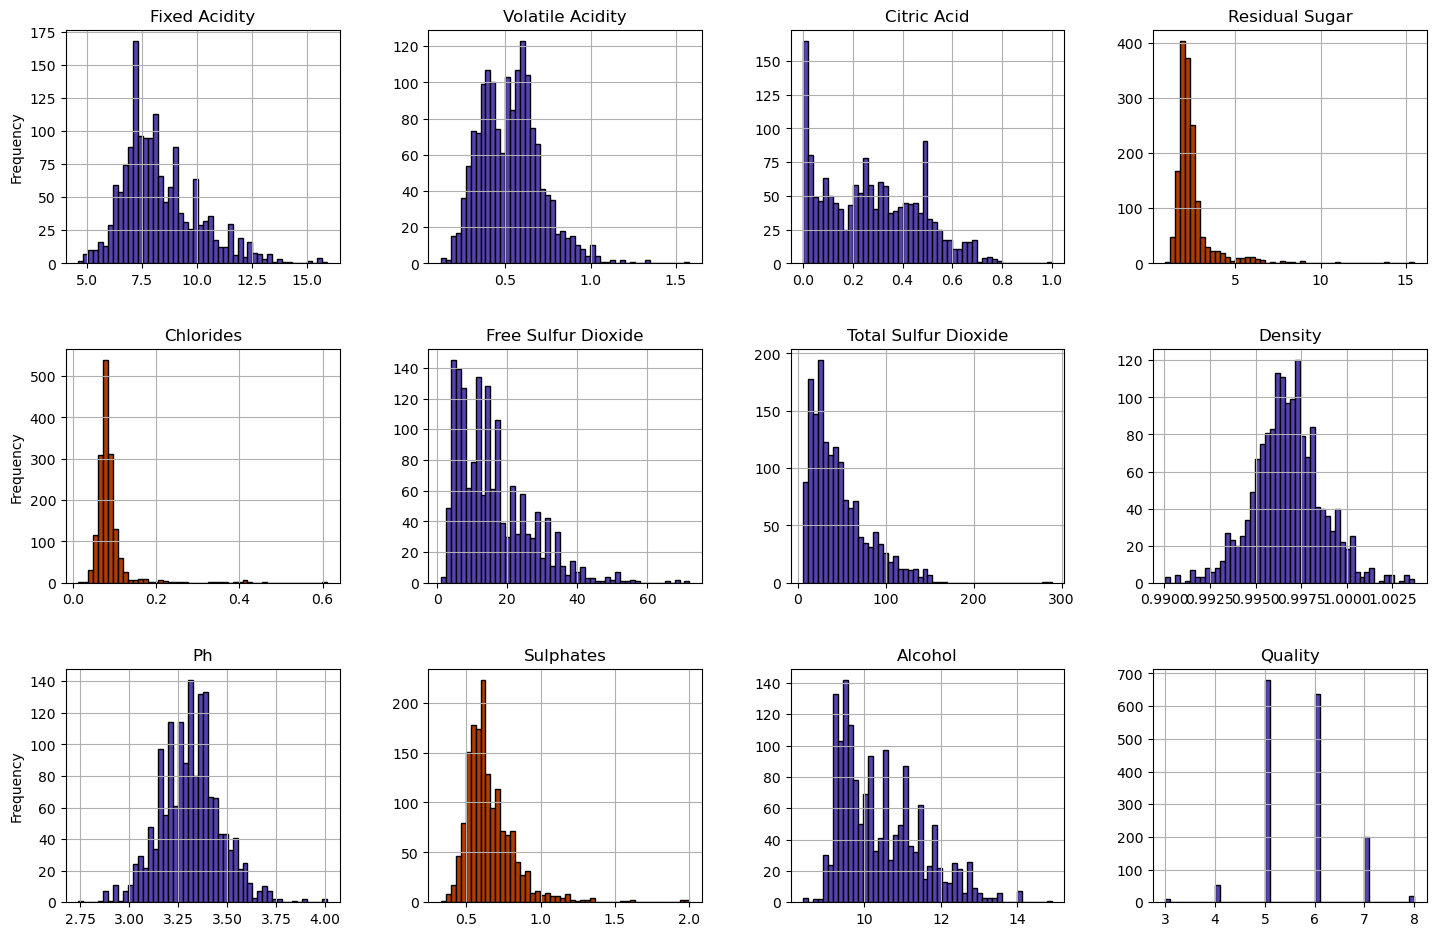

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    if col in ['chlorides', 'residual sugar', 'sulphates']:
        df[col].hist(ax=axes[i], bins=50, edgecolor='black', color="#b03c06")
    else:
        df[col].hist(ax=axes[i], bins=50, edgecolor='black', color="#5743b0")

    title = col.replace('_', ' ').title()
    axes[i].set_title(title, fontsize=12)

    # Set the y-label only for the first plot in each row
    if i % 4 == 0:
        axes[i].set_ylabel('Frequency', fontsize=10)
    else:
        axes[i].set_ylabel('')
plt.tight_layout(pad=3.0)
plt.show()

## Duplicates, a little note
In a chemical/wine context, two samples can be similar, however, in our case when we do a random split we could have the "same" observation in Train and in Test and the algo wouldn't be robust. That way, we decide to drop the 240 duplicates.

In [30]:
duplicates = df.duplicated().sum()
print(f"\nNumber of detected duplicates: {duplicates}")
df = df.drop_duplicates()


Number of detected duplicates: 240


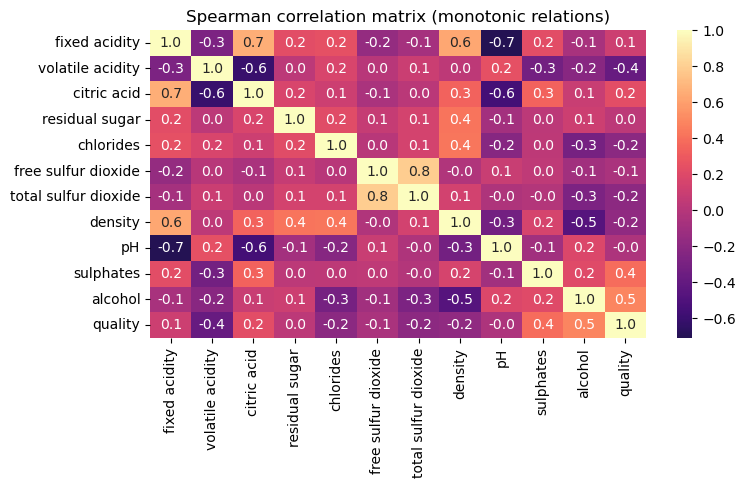

In [60]:
# Correlation matrix using Spearman method
plt.figure(figsize=(8, 4))
# Usamos Spearman porque las relaciones químicas no son necesariamente lineales
corr_matrix = df.corr(method='spearman') 
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='magma', center=0)
plt.title("Spearman correlation matrix (monotonic relations)")
plt.show()



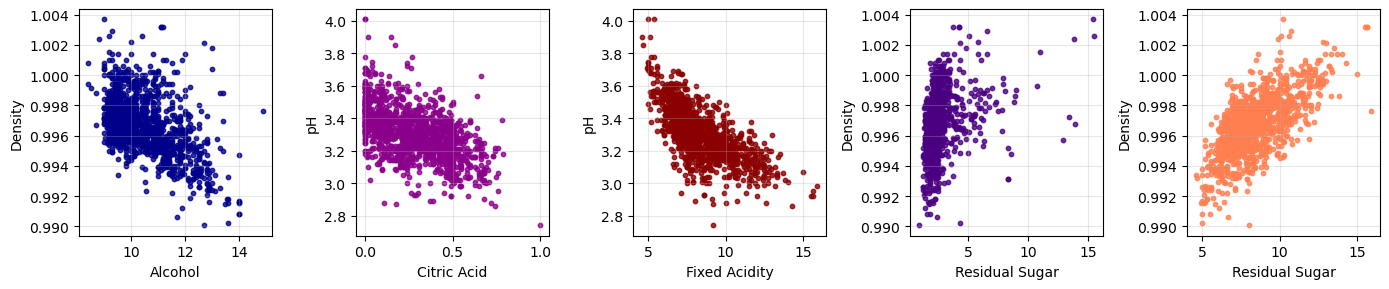

In [56]:
# Create individual scatter plots with marginal distributions
fig, axes = plt.subplots(1, 5, figsize=(14, 3))

# Plot 1: Density vs Alcohol
axes[0].scatter(df['alcohol'], df['density'], alpha=0.8, s=10, color='darkblue')
axes[0].set_xlabel('Alcohol')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)

# Plot 2: pH vs Citric Acid
axes[1].scatter(df['citric acid'], df['pH'], alpha=0.8, s=10, color='darkmagenta')
axes[1].set_xlabel('Citric Acid')
axes[1].set_ylabel('pH')
axes[1].grid(True, alpha=0.3)

# Plot 3: pH vs Fixed Acidity
axes[2].scatter(df['fixed acidity'], df['pH'], alpha=0.8, s=10, color='darkred')
axes[2].set_xlabel('Fixed Acidity')
axes[2].set_ylabel('pH')
axes[2].grid(True, alpha=0.3)

# Plot 4: Density vs Residual Sugar
axes[3].scatter(df['residual sugar'], df['density'], alpha=0.8, s=10, color='indigo')
axes[3].set_xlabel('Residual Sugar')
axes[3].set_ylabel('Density')
axes[3].grid(True, alpha=0.3)

axes[4].scatter(df['fixed acidity'], df['density'], alpha=0.8, s=10, color='coral')
axes[4].set_xlabel('Residual Sugar')
axes[4].set_ylabel('Density')
axes[4].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

## Correlation Analysis

The heatmap displays the correlation structure of our wine features, and the scatterplots provide visual evidence of the monotonic relationships observed in the heatmap. Our data is **ordinal**: an acidity of 7 is meaningfully less than an acidity of 11, the order matters, that's why we use Spearman correlation coeffitient rather than Pearson, to apply a rank to data. However, note that there is minimal difference between Pearson and Spearman correlations in our dataset, indicating that the dependencies are predominantly **linear** rather than just monotonic.

Difference:
- **Pearson Correlation** measures *linear* relationships: how well a straight line $y = \alpha x + \beta$ describes the relationship between two variables, rate of change is constant.
- **Spearman Correlation** measures *monotonic* relationships: whether two variables consistently move in the same direction (increasing or decreasingeither always increasing or always decreasing), regardless of whether the rate of change is constant.

From `corr_matrix`, we observe strong Spearman correlations that reflect underlying chemical/physical laws (Ref:ChatGPT):

- **Fixed Acidity vs pH** ($\rho \approx -0.71$): Negative, since $\text{pH} \approx -\log[H^+]$
- **Density vs Alcohol** ($\rho \approx -0.47$): Ethanol is less dense than water
- **Density vs Residual Sugar** ($\rho \approx 0.41$): Dissolved sugar increases specific gravity.

This high linear correlations won't break our predictions, but will break our interpretation. One of the great advantages of RF is the explicability via feature importance which is based on how much a feature decreases impurity when a split is made. The problem is that if Feature A and Feature B are highly correlated, they contain almost the same information. The tree will arbitrarily choose one or the other to make a split. Therefore, the "importance" score gets split between the two variables. Instead of Feature A having a score of 0.4, Feature A gets 0.2 and Feature B gets 0.2.  This is why permutation importance and feature selection become critical(maybe removing one feature?).

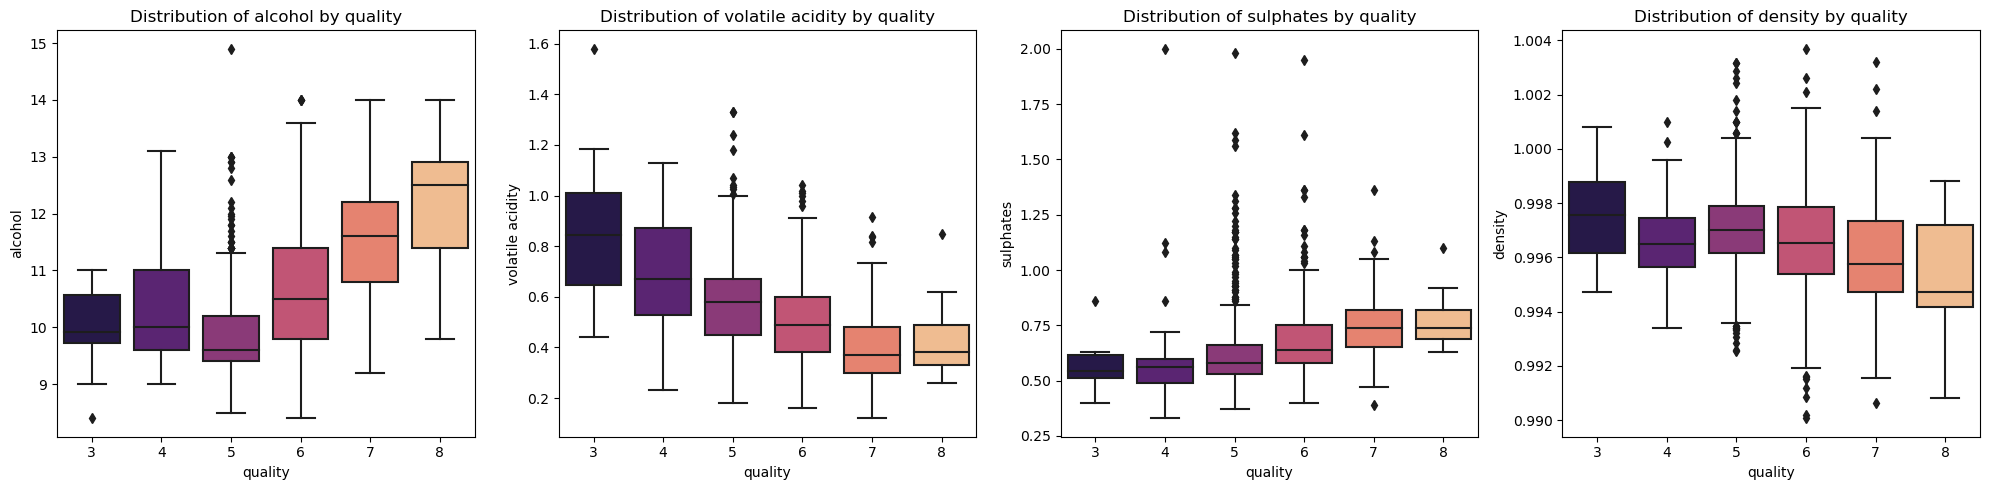

In [57]:
# Boxplot to see the separation classes
features = ['alcohol', 'volatile acidity', 'sulphates', 'density']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, col in enumerate(features):
    sns.boxplot(x='quality', y=col, data=df, ax=axes[i], palette='magma')
    axes[i].set_title(f'Distribution of {col} by quality')

plt.tight_layout()
plt.show()

## Class Separation 

The boxplots reveal that clear multiclass separation is not visually apparent. We observe that higher `alcohol` median quality increases. However, with `sulphates` and `density` features, we see significant overlap between the quality boxes, indicating that no simple hyperplane (single split) can cleanly separate good wines from bad wines. This overlap suggests that the problem requires a more complex, nonlinear decision that Random Forests can capture.

## Conclusion

We've observed in other Kaggle notebooks that simple Linear Regression or default Random Forest models achieve near-perfect accuracy.That's why our goal here is not to demonstrate spectacular performance, but rather to validate the theoretical results presented in lecture, comment how the parameter choices impact the results, and explore different split criteria.

We want to explore the next things:
- Individual trees **overfitting catastrophically** on the training set
- Random Forests **dramatically improving generalization** through ensemble averaging
- Watch the The "Dilution" of Feature Importance— and permutation importance the solution metric.

This EDA has justified our modeling strategy: focus on bagging vs. boosting to demonstrate the **bias-variance tradeoff** in action.